In [48]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score, plot_roc_curve, accuracy_score
from sklearn.preprocessing import StandardScaler

In [5]:
## 4.1 Loading and Cleaning the Data for Comparative Modeling

df = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

# to make all columns camel case and labeled the same way
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})

# EDA indicated 3 columns were irrelevant:

df = df.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)

# EDA indicated fraudulent transactions only occur in CASH_OUT and TRANSFER types

df = df[(df['type'] == 'CASH_OUT' ) | (df['type'] == 'TRANSFER')]

df = pd.get_dummies(columns = ['type'], drop_first = True, data = df)

In [6]:
df.head()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,type_TRANSFER
2,1,181.00,181.0,0.0,0.0,0.00,1,1
3,1,181.00,181.0,0.0,21182.0,0.00,1,0
15,1,229133.94,15325.0,0.0,5083.0,51513.44,0,0
19,1,215310.30,705.0,0.0,22425.0,0.00,0,1
24,1,311685.89,10835.0,0.0,6267.0,2719172.89,0,1


In [13]:
X = df.drop(columns = ['isFraud'])
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    random_state=42, 
                                                    stratify = y)

baseline = LogisticRegression()

In [14]:
baseline.fit(X_train, y_train)

LogisticRegression()

In [15]:
preds = baseline.predict(X_test)

In [21]:
preds

array([0, 0, 0, ..., 0, 0, 0])

In [23]:
baseline_cm = confusion_matrix(y_test, preds)

In [24]:
baseline_cm_df = pd.DataFrame(baseline_cm, columns = ['Predicted Legit', 'Predicted Fraud'], index = ['Actual Legit', 'Actual Fraud'])

In [25]:
baseline_cm_df

,Predicted Legit,Predicted Fraud
Actual Legit,689553,997
Actual Fraud,1183,870


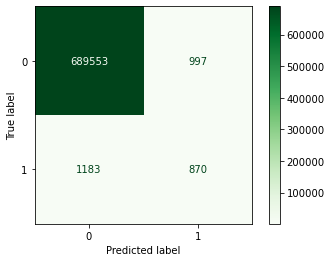

In [28]:
plot_confusion_matrix(baseline, X_test, y_test, cmap= 'Greens')

In [30]:
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

In [34]:
spec = tn/(tn + fp)
sense = tp/(tp+fn)
print(f"Specificity: {spec}")
print(f"Sensitivity: {sense}")

Specificity: 0.9985562233002679
Sensitivity: 0.4237700925474915


In [36]:
pred_proba = [i[1] for i in baseline.predict_proba(X_test)]
baseline_pred_df = pd.DataFrame({'true_values': y_test,
                                'pred_probs': pred_proba})
baseline_pred_df.head()

,true_values,pred_probs
5611919,0,4.092824e-25
4804226,0,4.360963e-07
5932106,0,2.753828e-14
3680497,0,5.766807e-12
1390325,0,2.389035e-34


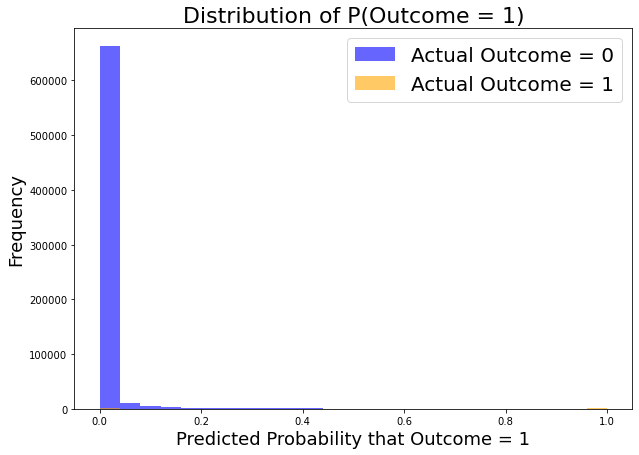

In [40]:
plt.figure(figsize = (10, 7))
plt.hist(baseline_pred_df[baseline_pred_df['true_values'] == 0]['pred_probs'],
         bins = 25,
         color = 'b',
         alpha = 0.6,
         label = 'Actual Outcome = 0')
plt.hist(baseline_pred_df[baseline_pred_df['true_values'] == 1]['pred_probs'],
         bins = 25,
         color = 'orange',
         alpha = 0.6,
         label = 'Actual Outcome = 1')

plt.title('Distribution of P(Outcome = 1)', fontsize = 22)
plt.ylabel('Frequency', fontsize = 18)
plt.xlabel('Predicted Probability that Outcome = 1', fontsize = 18)

plt.legend(fontsize = 20);

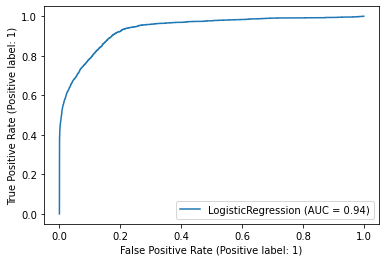

In [43]:
plot_roc_curve(baseline, X_test, y_test);

In [46]:
cross_val_score(baseline, X, y)

array([0.97531412, 0.99832877, 0.99820424, 0.99791728, 0.99775845])

In [49]:
accuracy_score(y_test, preds)

0.9968524537144656

Okay, the baseline isn't performing overly well, the AUC is 0.94, the accuracy is 99.7 %-  and if we predicted everything was not fraudulent, we'd have an overall accuracy of 99.8%.  Because we're dealing with a highly unbalanced class here, we'll need to try out a few methods to see if we can improve the model.  